In [1]:
import pymongo
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Evaluate Classifiers on Hand-Labeled Data
We have annotated 1149 of the Telegram messages by hand in order to be able to evaluate our classifiers on this dataset. Due to a lack of time and resources we did only a binary annotation, so we treat the fine-grained classifiers as binary classifiers in this evaluation.

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017/")

In [3]:
neutral_label = 0
offensive_label = 1

We get the labels of the annotated data from the dataset.

In [4]:
messages_collection = client.telegram.messages


def get_annotated_messages():
    query = {'gold_label': {'$exists': True}}
    query_res = messages_collection.find(query, {"hate_germeval_18": 1, "hate_germeval_19": 1, 
                                                "hate_germeval_1819": 1, "toxicity_score_preprocessed": 1, "toxicity_score": 1,
                                                "hate_hasoc_2020": 1, "hate_hasoc_1920": 1, "hate_covid_2021": 1, 
                                                "gold_label": 1, "hate_germeval_18_task_2": 1, 'hate_germeval_19_task_2': 1,
                                                'hate_germeval_1819_task_2': 1, 'hate_hasoc_2020_task_2': 1, 
                                                'hate_hasoc_1920_task_2': 1})
    messages = [msg for msg in query_res]
    return messages

In [5]:
annotated_messages = get_annotated_messages()
print(len(annotated_messages))

1149


As the different classifiers have different labels, we define a helper function to get the label as a numeric value

In [5]:
def get_label(msg, classifier):
    if classifier == "perspective_api":
        score = 0
        if "toxicity_score_preprocessed" in msg:
            score = msg['toxicity_score_preprocessed']
        else:
            score = msg['toxicity_score']
        return offensive_label if score > 0.5 else neutral_label
    
    if classifier in ["hate_germeval_18", "hate_germeval_19", "hate_germeval_1819"]:
        return offensive_label if msg[classifier]['label'] == 'OFFENSE' else neutral_label
    
    if classifier in ["hate_hasoc_2020", "hate_hasoc_1920"]:
        return offensive_label if msg[classifier]['label'] == 'HOF' else neutral_label
    
    if classifier == "hate_covid_2021":
        return offensive_label if msg[classifier]['label'] == 'abusive' else neutral_label
    
    if classifier in ["hate_germeval_18_task_2", "hate_germeval_19_task_2", "hate_germeval_1819_task_2"]:
        return neutral_label if msg[classifier]['label'] == 'OTHER' else offensive_label
    
    if classifier in ["hate_hasoc_2020_task_2", "hate_hasoc_1920_task_2"]:
        return neutral_label if msg[classifier]['label'] == 'NONE' else offensive_label

In [6]:
def get_gold_label(msg):
    return offensive_label if msg['gold_label'] == 'OFFENSIVE_ABUSIVE' else neutral_label

For the statistics, let's see how many of the annotated messages are neutral and how many are offensive

In [8]:
neutral_count = 0
offensive_count = 0
for msg in annotated_messages:
    label = get_gold_label(msg)
    if label == neutral_label:
        neutral_count += 1
    elif label == offensive_label:
        offensive_count += 1
print('Neutral messages: ', neutral_count)
print('Offensive messages: ', offensive_count)

Neutral messages:  968
Offensive messages:  181


Get the labels of each classifier for each message...

In [9]:
gold_labels = []
germeval_18 = []
germeval_19 = []
germeval_1819 = []
hasoc_2020 = []
hasoc_1920 = []
covid = []
perspective = []
germeval_18_task_2 = []
germeval_19_task_2 = []
germeval_1819_task_2 = []
hasoc_2020_task_2 = []
hasoc_1920_task_2 = []
for msg in annotated_messages:
    gold_labels.append(get_gold_label(msg))
    germeval_18.append(get_label(msg, 'hate_germeval_18'))
    germeval_19.append(get_label(msg, 'hate_germeval_19'))
    germeval_1819.append(get_label(msg, 'hate_germeval_1819'))
    hasoc_2020.append(get_label(msg, 'hate_hasoc_2020'))
    hasoc_1920.append(get_label(msg, 'hate_hasoc_1920'))
    covid.append(get_label(msg, 'hate_covid_2021'))
    perspective.append(get_label(msg, 'perspective_api'))
    germeval_18_task_2.append(get_label(msg, 'hate_germeval_18_task_2'))
    germeval_19_task_2.append(get_label(msg, 'hate_germeval_19_task_2'))
    germeval_1819_task_2.append(get_label(msg, 'hate_germeval_1819_task_2'))
    hasoc_2020_task_2.append(get_label(msg, 'hate_hasoc_2020_task_2'))
    hasoc_1920_task_2.append(get_label(msg, 'hate_hasoc_1920_task_2'))

In [25]:
def evaluate(gold_labels, classifier_labels):
    print('Accuracy: ', accuracy_score(gold_labels, classifier_labels))
    print('Precision: ', precision_score(gold_labels, classifier_labels, average="binary"))
    print('Recall: ', recall_score(gold_labels, classifier_labels, average="binary"))
    print('Macro F1 score: ', f1_score(gold_labels, classifier_labels, average="macro"))
    matrix = confusion_matrix(gold_labels, classifier_labels, normalize='true')
    ticklabels = ['NEUTRAL', 'OFFENSIVE']
    ax = sns.heatmap(matrix, cmap='rocket_r', annot=True, square=True,xticklabels=ticklabels
                     , yticklabels=ticklabels)
    figure = plt.gcf()
    figure.set_size_inches(3, 3)
    plt.show()

Now we can evaluate our classifiers. We will compute the accuracy, the precision, the recall, the Macro F1 score and the confusion matrix.

Accuracy:  0.7763272410791993
Precision:  0.36428571428571427
Recall:  0.56353591160221
Macro F1 score:  0.6513071274134831


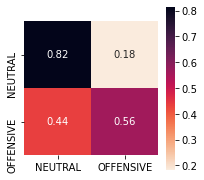

In [26]:
evaluate(gold_labels, germeval_18)

Accuracy:  0.6919060052219321
Precision:  0.3115468409586057
Recall:  0.7900552486187845
Macro F1 score:  0.6166823733413751


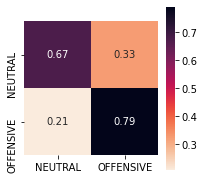

In [27]:
evaluate(gold_labels, germeval_19)

Accuracy:  0.8268059181897301
Precision:  0.4594594594594595
Recall:  0.56353591160221
Macro F1 score:  0.7005951406666362


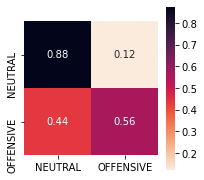

In [28]:
evaluate(gold_labels, germeval_1819)

Accuracy:  0.8302872062663186
Precision:  0.45569620253164556
Recall:  0.39779005524861877
Macro F1 score:  0.6626190895661955


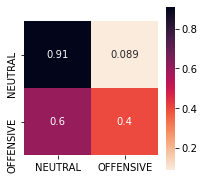

In [29]:
evaluate(gold_labels, hasoc_2020)

Accuracy:  0.8407310704960835
Precision:  0.49390243902439024
Recall:  0.44751381215469616
Macro F1 score:  0.6879316102317505


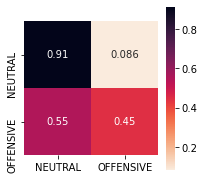

In [30]:
evaluate(gold_labels, hasoc_1920)

Accuracy:  0.8215839860748477
Precision:  0.4562043795620438
Recall:  0.6906077348066298
Macro F1 score:  0.7191094309922308


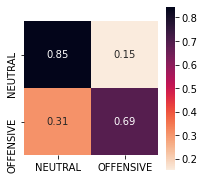

In [31]:
evaluate(gold_labels, covid)

Accuracy:  0.7841601392515231
Precision:  0.40233236151603496
Recall:  0.7624309392265194
Macro F1 score:  0.6934602442403848


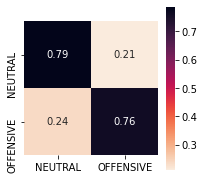

In [32]:
evaluate(gold_labels, perspective)

Accuracy:  0.8285465622280244
Precision:  0.4574468085106383
Recall:  0.47513812154696133
Macro F1 score:  0.6819996038218548


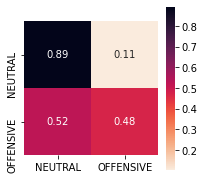

In [33]:
evaluate(gold_labels, germeval_18_task_2)

Accuracy:  0.7615317667536988
Precision:  0.36443148688046645
Recall:  0.6906077348066298
Macro F1 score:  0.6613230117817155


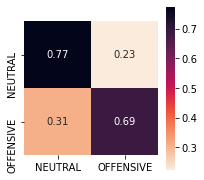

In [34]:
evaluate(gold_labels, germeval_19_task_2)

Accuracy:  0.8215839860748477
Precision:  0.4423076923076923
Recall:  0.5082872928176796
Macro F1 score:  0.6828108230395595


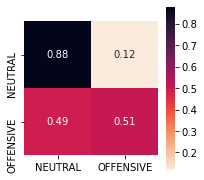

In [35]:
evaluate(gold_labels, germeval_1819_task_2)

Accuracy:  0.8067885117493473
Precision:  0.41350210970464135
Recall:  0.5414364640883977
Macro F1 score:  0.6754072075740608


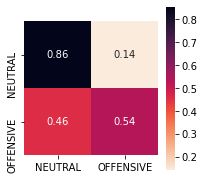

In [36]:
evaluate(gold_labels, hasoc_2020_task_2)

Accuracy:  0.8476936466492603
Precision:  0.515
Recall:  0.569060773480663
Macro F1 score:  0.7246969715640005


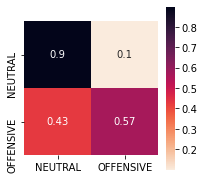

In [37]:
evaluate(gold_labels, hasoc_1920_task_2)

Now let's see how a ensemble model would perform

In [38]:
majority_vote = []
for i in range(len(gold_labels)):
    label_sum = germeval_18[i] + germeval_19[i] + germeval_1819[i] + hasoc_2020[i] + hasoc_1920[i] + covid[i] + germeval_18_task_2[i] + germeval_19_task_2[i] + germeval_1819_task_2[i] + hasoc_2020_task_2[i] + hasoc_1920_task_2[i]
    label = offensive_label if label_sum > 5 else neutral_label
    majority_vote.append(label)

Accuracy:  0.8511749347258486
Precision:  0.5240384615384616
Recall:  0.6022099447513812
Macro F1 score:  0.735417808486657


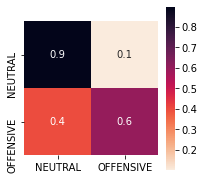

In [39]:
evaluate(gold_labels, majority_vote)

# 2. Performance on long messages
Let's see if the splitting of long messages had any influence on the performance of the classifiers. We will filter those messages out of the annotated ones, that were split due to their large number of tokens. Then we will evaluate the classifiers only on those messages.

In [7]:
query = {'gold_label': {'$exists': True}}
query_res = messages_collection.find(query, {'text': 1, 'link_preview_title': 1, 'link_preview': 1})
messages = [msg for msg in query_res]

We did some preprocessing before the splitting so we have to do the same preprocessing here. The next cell is the preprocessing.py file in the helper directory.

In [9]:
import emoji
import numpy as np
import re
from langdetect import detect
import pandas as pd 
import gensim

from nltk.corpus import stopwords
stop_words_ger = stopwords.words('german')
stop_words_en = stopwords.words('english')

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

import spacy
nlp = spacy.load("de_core_news_sm")

def prepare_single_text(text):

    text = remove_hand_selected_words(text)    
    text = rermove_repeating_chars(text)
    text = emoji_2_text(text)
    text= " ".join(tw_process.pre_process_doc(text))
    text = remove_special_chars(text)
    #text = text.lower()
    text = remove_white_spaces(text)

    return(text)

def prepare_single_text_without_ekphrasis(text):

    text = remove_hand_selected_words(text)    
    text = rermove_repeating_chars(text)
    text = emoji_2_text(text)
    text= remove_usernames(text)
    text = remove_URLs(text)
    text = remove_special_chars(text)
    #text = text.lower()
    text = remove_white_spaces(text)

    return(text)


def remove_usernames(string):
    return re.sub('@\S+', '<name>', string)	

def remove_URLs(string):
    return re.sub('http[s]?://\S+', '<url>', string)

def get_text_processor():
    return(TextPreProcessor(
        normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'url', 'date', 'number'],
        
        segmenter="twitter", 
        corrector="twitter", 
        
        fix_html=True,  # fix HTML tokens

        unpack_hashtags=False,  # perform word segmentation on hashtags
        unpack_contractions=False,  # Unpack contractions (can't -> can not)
        spell_correct_elong=False,  # spell correction for elongated words

        tokenizer=SocialTokenizer(lowercase=False).tokenize,
        dicts=[emoticons]
    ))
tw_process = get_text_processor()

def remove_numbers(s):
    return(re.sub(" \d+", " ", s))

def lemmatize_tokens(tokens):
    txt = " ".join(tokens)
    doc = nlp(txt)
    return([token.lemma_ for token in doc])

def keepOnlyNounsAndNE(tokens):
    txt = " ".join(tokens)
    doc = nlp(txt)
    
    keep = [str(w) for w in list(doc.ents)]
    for w in doc:
        if w.pos_ in ['NOUN']:
            keep.append(str(w.text))
    return([w for w in tokens if w in keep])
 
def make_bigrams(texts,bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def build_N_grams(text,threshold):
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(text, min_count=5, threshold=threshold) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[text], threshold=threshold)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    data_words_bigrams = make_bigrams(text, bigram_mod)
    return(data_words_bigrams)

def remove_stopwords(tweet):
    txt = []
    for w in tweet:
        if w in stop_words_ger:
            continue
            
        if w in stop_words_en:
            continue
        txt.append(w)

    return(txt)

def remove_hand_selected_words(text):
    return(re.sub(r"\|lbr\||\|LBR\||\|AMP\||&gt;|&amp;", " ", text))

def rermove_repeating_chars(text):
    to_remove = ".,?!"
    return(re.sub("(?P<char>[" + re.escape(to_remove) + "])(?P=char)+", r"\1", text))

from emoji import EMOJI_UNICODE, UNICODE_EMOJI
UNICODE_EMOJI = {v.encode('unicode-escape').decode().replace("\\", "").lower(): "<"+k.replace(":","").replace('-','')+">" for k, v in EMOJI_UNICODE['en'].items()}

def emoji_2_text(text):
    
    text = emoji.demojize(text, delimiters=("<",">"))
    re_matches = re.findall(r"(<U\+[0-9a-zA-Z]*>)", text)
    
     
    for emoji_unicode in re_matches:
        try:
            text = text.replace(emoji_unicode, UNICODE_EMOJI[re.sub('[<>+]', '', emoji_unicode).lower()])
        except:
            text = text.replace(emoji_unicode,"")
    
        text = text.replace(emoji_unicode,"")
        
    m = re.search('<[a-z_-]*(-)[a-z_-]*>',text)
    if m is not None:
        old_emoji = m.group(0)
        new_emoji = m.group(0).replace('-','_')
        text = text.replace(old_emoji,new_emoji)
    return(text)

def remove_special_chars(text):
    return(re.sub(r"[^A-Za-z0-9\säüßöÖÄÜ<>_:!?.,\-]+", " ", text))

def detect_language(tw):
    try:
        return(detect(tw))
    except:
        return("unk")
    
def sentence_to_token(text):
    return([w.strip() for w in text.split()])

def token_to_sentence(token):
    return(" ".join([w.strip() for w in token]))

def remove_white_spaces(text):
    return(" ".join(text.split()))

/home/ubuntu/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Reading twitter - 1grams ...


/home/ubuntu/anaconda3/lib/python3.8/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Now we perform the exact same steps as in the inferencing part, and save the message if it was split.

In [16]:
max_length = 412
long_messages = []
for msg in messages:
    combined_text = msg['text']
    if msg['link_preview_title'] is not None:
        combined_text = combined_text + ". " +  msg['link_preview_title']
    if msg['link_preview'] is not None:
        combined_text = combined_text + ". " +  msg['link_preview']

    combined_text = combined_text.replace('. . ','. ')
    text = prepare_single_text(combined_text)
    
    if len(text.split(' ')) > max_length:
        long_messages.append(msg['_id'])
print(len(long_messages))

39


Only 39 messages are long enough to be split. NOTE THAT THIS IS PROBABLY NOT ENOUGH TO DRAW REASONABLE CONCLUSIONS: However, let us do the analysis anyway. First start with getting the labels of those messages

In [47]:
from bson.objectid import ObjectId

long_messages_labels = []

for _id in long_messages:
    query = {'_id': ObjectId(_id)}
    msg = messages_collection.find_one(query, {"hate_germeval_18": 1, "hate_germeval_19": 1, 
                                                "hate_germeval_1819": 1, "toxicity_score_preprocessed": 1, "toxicity_score": 1,
                                                "hate_hasoc_2020": 1, "hate_hasoc_1920": 1, "hate_covid_2021": 1, 
                                                "gold_label": 1, "hate_germeval_18_task_2": 1, 'hate_germeval_19_task_2': 1,
                                                'hate_germeval_1819_task_2': 1, 'hate_hasoc_2020_task_2': 1, 
                                                'hate_hasoc_1920_task_2': 1})
    long_messages_labels.append(msg)

In [48]:
gold_labels = []
germeval_18 = []
germeval_19 = []
germeval_1819 = []
hasoc_2020 = []
hasoc_1920 = []
covid = []
perspective = []
germeval_18_task_2 = []
germeval_19_task_2 = []
germeval_1819_task_2 = []
hasoc_2020_task_2 = []
hasoc_1920_task_2 = []
for msg in long_messages_labels:
    gold_labels.append(get_gold_label(msg))
    germeval_18.append(get_label(msg, 'hate_germeval_18'))
    germeval_19.append(get_label(msg, 'hate_germeval_19'))
    germeval_1819.append(get_label(msg, 'hate_germeval_1819'))
    hasoc_2020.append(get_label(msg, 'hate_hasoc_2020'))
    hasoc_1920.append(get_label(msg, 'hate_hasoc_1920'))
    covid.append(get_label(msg, 'hate_covid_2021'))
    perspective.append(get_label(msg, 'perspective_api'))
    germeval_18_task_2.append(get_label(msg, 'hate_germeval_18_task_2'))
    germeval_19_task_2.append(get_label(msg, 'hate_germeval_19_task_2'))
    germeval_1819_task_2.append(get_label(msg, 'hate_germeval_1819_task_2'))
    hasoc_2020_task_2.append(get_label(msg, 'hate_hasoc_2020_task_2'))
    hasoc_1920_task_2.append(get_label(msg, 'hate_hasoc_1920_task_2'))

In [63]:
print('Offenisve messages: ', gold_labels.count(offensive_label))
print('Neutral messages: ', gold_labels.count(neutral_label))

Offenisve messages:  12
Neutral messages:  27


And once again evaluate the classifiers on this subset of messages

Accuracy:  0.717948717948718
Precision:  0.6
Recall:  0.25
Macro F1 score:  0.5863066538090647


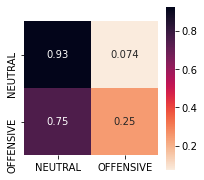

In [49]:
evaluate(gold_labels, germeval_18)

Accuracy:  0.6410256410256411
Precision:  0.45
Recall:  0.75
Macro F1 score:  0.6290760869565217


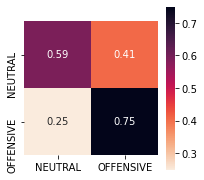

In [50]:
evaluate(gold_labels, germeval_19)

Accuracy:  0.7435897435897436
Precision:  0.75
Recall:  0.25
Macro F1 score:  0.6068548387096775


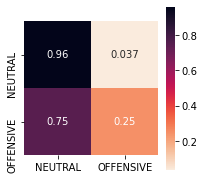

In [51]:
evaluate(gold_labels, germeval_1819)

Accuracy:  0.7435897435897436
Precision:  0.5625
Recall:  0.75
Macro F1 score:  0.7214285714285714


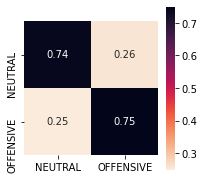

In [52]:
evaluate(gold_labels, hasoc_2020)

Accuracy:  0.6666666666666666
Precision:  0.47368421052631576
Recall:  0.75
Macro F1 score:  0.6520247083047358


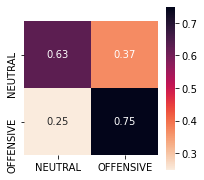

In [53]:
evaluate(gold_labels, hasoc_1920)

Accuracy:  0.6410256410256411
Precision:  0.42857142857142855
Recall:  0.5
Macro F1 score:  0.5961538461538461


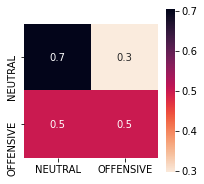

In [54]:
evaluate(gold_labels, covid)

Accuracy:  0.7948717948717948
Precision:  0.6666666666666666
Recall:  0.6666666666666666
Macro F1 score:  0.7592592592592593


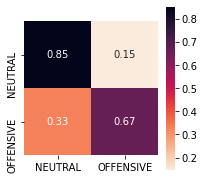

In [55]:
evaluate(gold_labels, perspective)

Accuracy:  0.7435897435897436
Precision:  0.6666666666666666
Recall:  0.3333333333333333
Macro F1 score:  0.6388888888888888


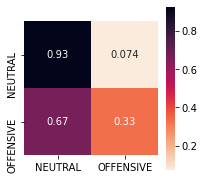

In [57]:
evaluate(gold_labels, germeval_18_task_2)

Accuracy:  0.6666666666666666
Precision:  0.46153846153846156
Recall:  0.5
Macro F1 score:  0.6173584905660378


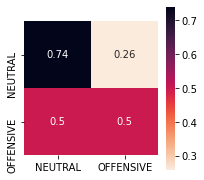

In [58]:
evaluate(gold_labels, germeval_19_task_2)

Accuracy:  0.7435897435897436
Precision:  0.75
Recall:  0.25
Macro F1 score:  0.6068548387096775


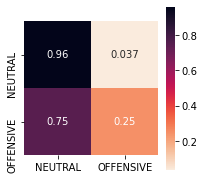

In [59]:
evaluate(gold_labels, germeval_1819_task_2)

Accuracy:  0.7435897435897436
Precision:  0.5714285714285714
Recall:  0.6666666666666666
Macro F1 score:  0.7115384615384615


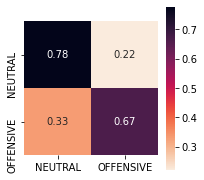

In [60]:
evaluate(gold_labels, hasoc_2020_task_2)

Accuracy:  0.7948717948717948
Precision:  0.6428571428571429
Recall:  0.75
Macro F1 score:  0.7692307692307693


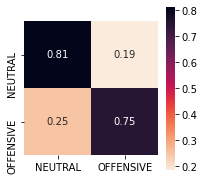

In [61]:
evaluate(gold_labels, hasoc_1920_task_2)